# Projet d'analyse des résultats des détections des exoplanètes par le télescope Kepler

Source : This file was produced by the NASA Exoplanet Archive  http://exoplanetarchive.ipac.caltech.edu
Tue Jan 23 10:50:14 2024

### Objectif :
A partir de la validité des résultats de détection des exoplanètes par le télescope Kepler obtenir un modèle de prédiction de la probabilité d'avoir un exoplanète sur une planète Terrestre.

### Modèle CNN 1D



In [64]:
import os
from datetime import datetime

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import metrics

import seaborn as sns

import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.models import load_model, save_model
from tensorflow.keras import regularizers


In [65]:

# Charger ensemble de données ici (new_data par exemple)
new_data = pd.read_csv('./dataset/data_resampled.csv')
new_data.head()

,koi_steff,koi_steff_err1,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_smet,koi_smet_err1,koi_smet_err2,koi_srad,...,koi_dicco_mdec_err,koi_dicco_msky,koi_dicco_msky_err,koi_dikco_mra,koi_dikco_mra_err,koi_dikco_mdec,koi_dikco_mdec_err,koi_dikco_msky,koi_dikco_msky_err,target
0,4499.0,89.0,-89.0,4.635,0.032,-0.020,-0.26,0.15,-0.15,0.639,...,0.210,0.210,0.190,-0.41,0.180,-0.43,0.220,0.59,0.190,1
1,5365.0,191.0,-175.0,3.669,0.816,-0.204,-0.04,0.30,-0.30,2.872,...,0.076,14.558,0.099,-13.90,0.072,4.37,0.081,14.57,0.077,0
2,6014.0,190.0,-211.0,4.436,0.072,-0.217,-0.04,0.25,-0.30,1.021,...,0.620,0.500,0.980,0.14,0.930,-0.40,0.620,0.42,0.860,1
3,4498.0,90.0,-90.0,4.661,0.012,-0.042,-0.08,0.15,-0.15,0.635,...,0.270,0.130,0.600,0.58,0.710,-0.25,0.270,0.63,0.590,1
4,5839.0,105.0,-105.0,4.327,0.156,-0.104,-0.28,0.15,-0.15,1.067,...,0.630,0.570,0.580,0.40,0.610,0.12,0.730,0.41,0.570,1


In [66]:

# Séparation des caractéristiques (X) et de la cible (y)
X = new_data.drop('target', axis=1)
y = new_data['target']

# Séparation des données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [67]:

# Normalisation des caractéristiques
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# Reshape des données pour convenir à l'entrée d'un CNN
X_train_reshaped = X_train_scaled.reshape(X_train_scaled.shape[0], X_train_scaled.shape[1], 1)
X_test_reshaped = X_test_scaled.reshape(X_test_scaled.shape[0], X_test_scaled.shape[1], 1)


Les modèles

In [68]:
def get_model1() :
    # Création du modèle CNN
    model = keras.Sequential([
        layers.Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train_scaled.shape[1], 1)),
        layers.MaxPooling1D(pool_size=2),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(1, activation='sigmoid')  # Utiliser 'softmax' si vplus de deux classes
    ])

    return model

def get_model2() :
    model = keras.Sequential([
        layers.Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train_scaled.shape[1], 1)),
        layers.BatchNormalization(),
        layers.MaxPooling1D(pool_size=2),
        layers.Conv1D(filters=128, kernel_size=3, activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling1D(pool_size=2),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ])

    return model

def get_model3() :
    model = keras.Sequential([
        layers.Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train_scaled.shape[1], 1)),
        layers.BatchNormalization(),
        layers.MaxPooling1D(pool_size=2),
        layers.Conv1D(filters=128, kernel_size=3, activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling1D(pool_size=2),
        layers.Conv1D(filters=256, kernel_size=3, activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling1D(pool_size=2),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ])
    return model

def get_model(filters, kernel_size, activation):
    model = keras.Sequential([
        layers.Conv1D(filters=filters, kernel_size=kernel_size, activation=activation, input_shape=(X_train_scaled.shape[1], 1)),
        layers.BatchNormalization(),
        layers.MaxPooling1D(pool_size=2),
        layers.Conv1D(filters=filters*2, kernel_size=kernel_size, activation=activation),
        layers.BatchNormalization(),
        layers.MaxPooling1D(pool_size=2),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(256, activation=activation),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ])
    
    return model

def get_ext_model(filters, kernel_size, activation):
    model = keras.Sequential([
        layers.Conv1D(filters=filters, kernel_size=kernel_size, activation=activation, input_shape=(X_train_scaled.shape[1], 1)),
        layers.BatchNormalization(),
        layers.MaxPooling1D(pool_size=2),
        layers.Conv1D(filters=filters*2, kernel_size=kernel_size+2, activation=activation),
        layers.BatchNormalization(),
        layers.MaxPooling1D(pool_size=2),
        layers.Flatten(),
        layers.Dropout(0.6),
        layers.Dense(256, activation=activation, kernel_regularizer=regularizers.l2(0.01)),
        layers.Dropout(0.6),
        layers.Dense(1, activation='sigmoid')
    ])
    
    return model


chargement du modèle

In [69]:

# model = get_model(activation='relu', filters=64, kernel_size=3)
model = get_ext_model(activation='leaky_relu', filters=64, kernel_size=3)

modele_nom = 'model7'
model.summary()

param_grid = {
    'optimizer': 'adam',
    'epochs': 32
}


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_11 (Conv1D)          (None, 48, 64)            256       
                                                                 
 batch_normalization_11 (Bat  (None, 48, 64)           256       
 chNormalization)                                                
                                                                 
 max_pooling1d_11 (MaxPoolin  (None, 24, 64)           0         
 g1D)                                                            
                                                                 
 conv1d_12 (Conv1D)          (None, 20, 128)           41088     
                                                                 
 batch_normalization_12 (Bat  (None, 20, 128)          512       
 chNormalization)                                                
                                                      

Les callbacks

In [70]:
# ---- Callback tensorboard


log_dir = "./logs/tb_" + modele_nom + "_" + datetime.now().strftime("%Y%m%d_%H%M%S")

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# ---- Callback ModelCheckpoint - Save best model
save_dir = "./models/best-"+modele_nom+".h5"
bestmodel_callback = tf.keras.callbacks.ModelCheckpoint(filepath=save_dir, verbose=0, monitor='val_accuracy', save_best_only=True)

# ---- Callback ModelCheckpoint - Save model each epochs
save_dir = "./models/"+modele_nom+"-{epoch:04d}.h5"
savemodel_callback = tf.keras.callbacks.ModelCheckpoint(filepath=save_dir, verbose=0)

path=os.path.abspath('./logs')
print(f'To run tensorboard :\ntensorboard --logdir {path}')

To run tensorboard :
tensorboard --logdir d:\David\Documents\workspace python\ML\Kepler-planets\logs


In [71]:

# Compilation du modèle
model.compile(optimizer=param_grid['optimizer'], loss='binary_crossentropy', metrics=['accuracy'])

In [72]:

# Entraînement du modèle
model.fit(X_train_reshaped, y_train, epochs=param_grid['epochs'], batch_size=32, validation_split=0.2,
                      callbacks=[tensorboard_callback, bestmodel_callback, savemodel_callback] )

model.save('./models/last-'+modele_nom+".h5")

Epoch 1/32


156/156 [==============================] - 26s 69ms/step - loss: 3.1380 - accuracy: 0.8584 - val_loss: 2.4345 - val_accuracy: 0.6161
Epoch 2/32
156/156 [==============================] - 8s 52ms/step - loss: 1.4589 - accuracy: 0.8909 - val_loss: 1.1526 - val_accuracy: 0.8024
Epoch 3/32
156/156 [==============================] - 10s 65ms/step - loss: 0.8183 - accuracy: 0.9034 - val_loss: 0.6667 - val_accuracy: 0.8964
Epoch 4/32
156/156 [==============================] - 6s 41ms/step - loss: 0.5894 - accuracy: 0.9052 - val_loss: 0.4775 - val_accuracy: 0.9181
Epoch 5/32
156/156 [==============================] - 26s 171ms/step - loss: 0.4509 - accuracy: 0.9138 - val_loss: 0.3707 - val_accuracy: 0.9325
Epoch 6/32
156/156 [==============================] - 6s 40ms/step - loss: 0.3901 - accuracy: 0.9173 - val_loss: 0.3422 - val_accuracy: 0.9301
Epoch 7/32
156/156 [==============================] - 5s 34ms/step - loss: 0.3740 - accuracy: 0.9154 - val_loss: 0.3230 - val_accuracy: 0.9317
Epoch 

#### Evaluation

In [73]:

# Évaluation du modèle
y_pred = model.predict(X_test_reshaped)

# Convertir les probabilités en classes binaires en utilisant un seuil (0.5 dans cet exemple)
y_pred_binary = (y_pred > 0.5).astype(int)


49/49 [==============================] - 1s 12ms/step


Accuracy: 0.9286632390745502


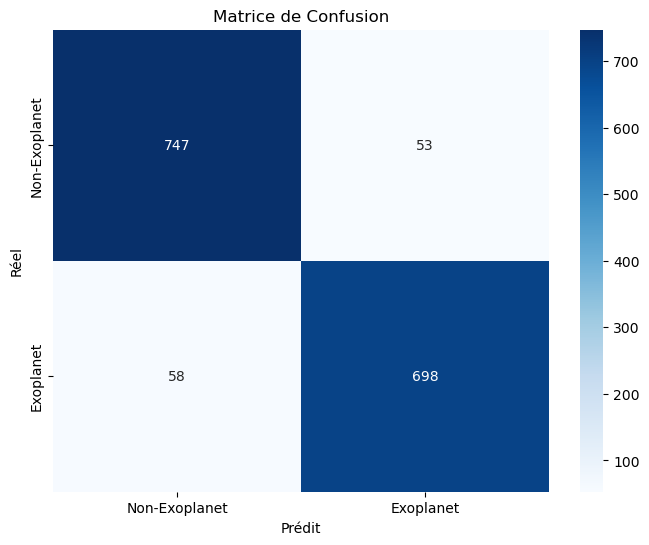

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.93      0.93       800
           1       0.93      0.92      0.93       756

    accuracy                           0.93      1556
   macro avg       0.93      0.93      0.93      1556
weighted avg       0.93      0.93      0.93      1556



In [74]:

# Calcul de l'accuracy
accuracy = accuracy_score(y_test, y_pred_binary)

print(f'Accuracy: {accuracy}')

# Affichage de la matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred_binary)
# Afficher la matrice de confusion avec seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Non-Exoplanet', 'Exoplanet'],
            yticklabels=['Non-Exoplanet', 'Exoplanet'])
plt.title('Matrice de Confusion')
plt.xlabel('Prédit')
plt.ylabel('Réel')
plt.show()

# Affichage du rapport de classification
class_report = classification_report(y_test, y_pred_binary)
print('Classification Report:')
print(class_report)

Meilleur modèle

49/49 [==============================] - 1s 9ms/step
val_Accuracy: 0.9466580976863753


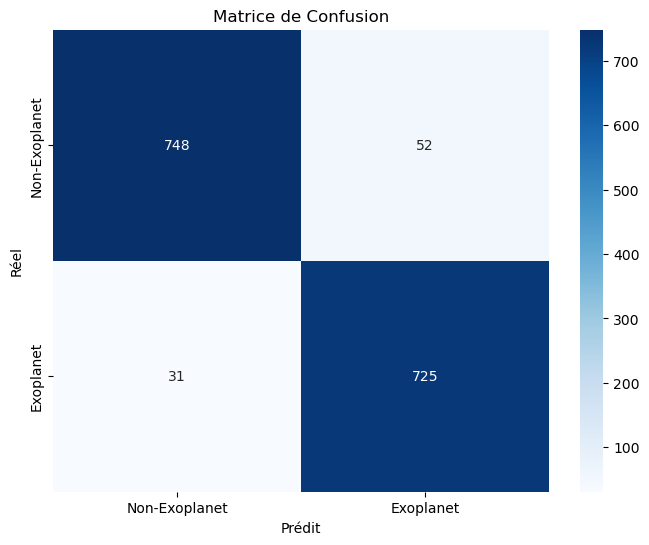

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.94      0.95       800
           1       0.93      0.96      0.95       756

    accuracy                           0.95      1556
   macro avg       0.95      0.95      0.95      1556
weighted avg       0.95      0.95      0.95      1556



In [80]:
# Charger le meilleur modèle
best_modele_nom = modele_nom
best_modele_nom = "model5"

best_model = load_model('./models/best-'+best_modele_nom+".h5")
##best_model = load_model('./models/model5_0034.h5")
# données du meilleur modèle 
#X_test_reshaped = X_test.reshape(-1, 1, 1)

#accuracy
y_pred = best_model.predict(X_test_reshaped)
y_pred_binary = (y_pred > 0.5).astype(int)
accuracy = accuracy_score(y_test, y_pred_binary)
print(f'val_Accuracy: {accuracy}')

# Affichage de la matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred_binary)
# Afficher la matrice de confusion avec seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Non-Exoplanet', 'Exoplanet'],
            yticklabels=['Non-Exoplanet', 'Exoplanet'])
plt.title('Matrice de Confusion')
plt.xlabel('Prédit')
plt.ylabel('Réel')
plt.show()

# Affichage du rapport de classification
class_report = classification_report(y_test, y_pred_binary)
print('Classification Report:')
print(class_report)